In [5]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(1, os.path.abspath(os.pardir))
import CONFIG

%reload_ext autoreload
%autoreload 2


In [6]:
import pandas as pd
import numpy as np
import cv2
import re

from PIL import Image

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt 
%matplotlib inline

In [7]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [8]:
INPUT_DIR = CONFIG.CFG.DATA.BASE

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
train_df.shape

(147793, 5)

In [10]:
NEW_COLUMNS = ['x' , 'y', 'w', 'h']

for column in NEW_COLUMNS:
    train_df[column] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1] * len(NEW_COLUMNS)
    return r 

train_df[NEW_COLUMNS] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)

for c in NEW_COLUMNS:
    train_df[c] = train_df[c].astype(np.float)


In [11]:
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [12]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-655]

In [13]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [14]:
image_ids[0]

'b6ab77fd7'

In [15]:
image_row = train_df[train_df['image_id'] == "b6ab77fd7"]
image_row.shape

(47, 8)

In [31]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = df['image_id'].unique()
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_row = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(os.path.join(self.image_dir, f"{image_id}.jpg"), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # range 0 to 1 for the model
        image /= 255.0

        boxes = image_row[NEW_COLUMNS].values
        area = boxes[:, 3] * boxes[:, 2]
        area = torch.as_tensor(area, dtype=torch.float32)

        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # no of boxes in the image, # images with image_id
        # since it's same class torch.ones
        labels = torch.ones((image_row.shape[0],), dtype=torch.int64)

        iscrowd = torch.zeros((image_row.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.tensor(sample['bboxes']).float()

        return image, target, image_id


In [17]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [19]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
train_dataset = WheatDataset(train_df, os.path.join(INPUT_DIR, "train"), get_train_transform())
valid_dataset = WheatDataset(valid_df, os.path.join(INPUT_DIR, "train"), get_valid_transform())

In [23]:
indices = torch.randperm(len(train_dataset)).tolist()

In [33]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [26]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [27]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

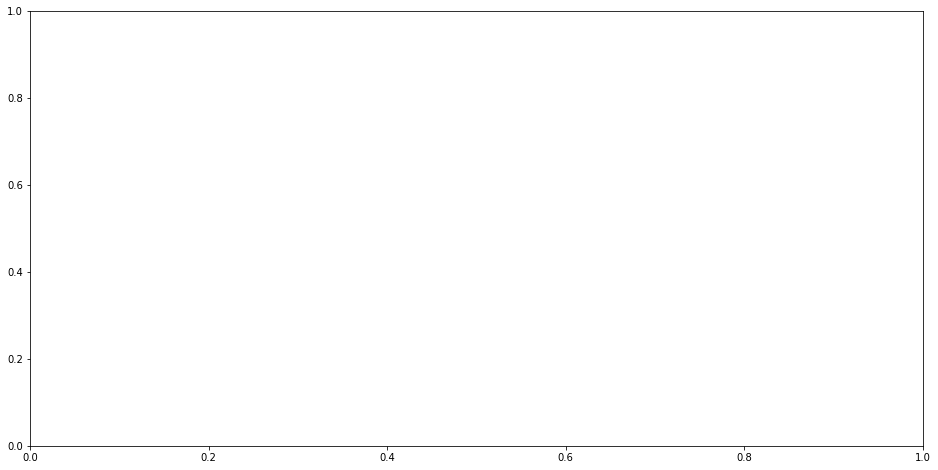

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

In [29]:
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [34]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2


# In[18]:


loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


RuntimeError: Expected object of scalar type double but got scalar type float for argument 'other'